In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from tqdm import tqdm

In [3]:
import torch
from torch import nn,optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split,Dataset

In [4]:
import torch
import torch.nn as nn 
from torch import Tensor

In [5]:
class DoubleConv(nn.Module):
    
    """
    A double convolutional Layer with 3x3, ReLU, and optional MaxPooling
    
    includes a foward method to pass argument forward
    
    Attributes:
    
        in_channels (int): The dimensin of the img 
        out_channels (int): The number of classification
        use_pooling (bool): Whether or not to use pooling
    """
    
    def __init__(self, in_channels:int, out_channels:int, use_pooling:bool=True):
        super().__init__()
        self.conv_op=nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        if use_pooling:
            self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
            
    def forward(self,x:Tensor)->Tensor:

        conv = self.conv_op(x)
        pooling = self.pool(conv)
        
        return pooling

class VGG13(nn.Module):
    
    def __init__(self, in_channels:int,num_channels:int):
        super().__init__()

        # 10 layers of Convolution
        self.block1 = DoubleConv(in_channels,64)
        self.block2 = DoubleConv(64,128)
        self.block3 = DoubleConv(128,256)
        self.block4 = DoubleConv(256,512)
        self.block5 = DoubleConv(512,512)

        # Fully connected layers
        self.fc=nn.Sequential(
            nn.Linear(7*7*512,4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096,num_channels)
        ) 

    def extract_features(self,x)->Tensor:
        
        down1 = self.block1(x)
        down2 = self.block2(down1)
        down3 = self.block3(down2)
        down4 = self.block4(down3)
        down5 = self.block5(down4)
        
        flatten_features = down5.flatten(start_dim=1)

        # Returns a tensor (7*512*512)
        return flatten_features
        
    def forward(self,x):
        
        flatten_x:torch.tensor = self.extract_features(x)
        output = self.fc(flatten_x)
        
        return output

In [6]:
class FaceDataset(Dataset):
    
    def __init__(self, root_path:str, transform=None):
        self.root_path=root_path
        
        self.transform = transform

        # create a dictionary labeling female_faces,male_faces,object to a number
        self.img_labels:dict[str:int]={dir_name:i for i,dir_name in enumerate(sorted(os.listdir(root_path)))}

        self.samples:list[tuple(str,int)] = []

        # Retrieving each image and saving it as a tuple to samples
        for folder_name in os.listdir(self.root_path):
            folder_path:str = os.path.join(self.root_path,folder_name)         
            for img in os.listdir(folder_path):
                try:
                    self.samples.append(( os.path.join(folder_path,img), self.img_labels[folder_name]))
                except Exception as e:
                    print(f'{e}')

    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self,index):
        
        img_path, label = self.samples[index]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return (img, label)

In [7]:
def get_mean_std(loader):
    # VAR[X] = E[X**2] - E[X]**2
    channels_sum, channels_squared_sum, num_batches=0,0,0
    
    for data,_ in loader:
        channels_sum += torch.mean(data,dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2,dim=[0,2,3])
        num_batches+=1

    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches - mean**2)**0.5

    return mean, std

In [22]:
# Training Variable

ROOT_PATH='../data/raw/Images'
IN_CHANNELS=3
OUT_CHANNELS=3
BATCH_SIZE = 8
LEARNING_RATE=0.01
EPOCHS=10

# Check is nvidia GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=(67.3686, 52.9727, 44.3268),std=(42.2854, 35.1020, 32.3488)),
    transforms.Resize((224,224),antialias=False)
])

# Initializing Datasets
dataset = FaceDataset(ROOT_PATH,transform)
generator = torch.Generator().manual_seed(42)

train_data,attack_data, test_data = random_split(dataset,[0.7,0.1,0.2],generator=generator)
print('Total number of dataset:',len(dataset))
print('Train                  :',len(train_data))
print('Attack                 :', len(attack_data))
print('Test                   :', len(test_data))


train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Setting up 
model = VGG13(IN_CHANNELS,OUT_CHANNELS).to(device)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

Total number of dataset: 5000
Train                  : 3500
Attack                 : 500
Test                   : 1000


tensor(0.) tensor(1.)


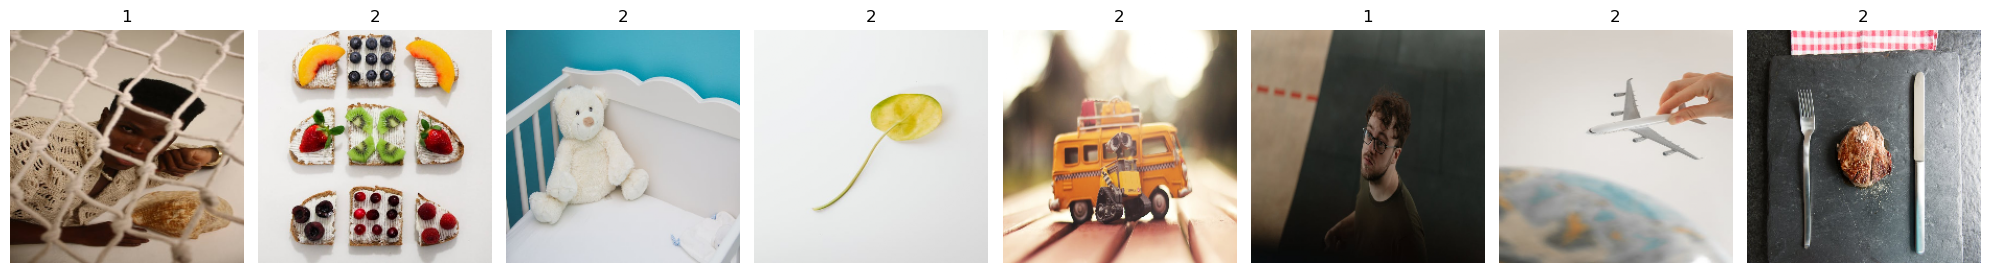

In [23]:
inputs, targets = next(iter(train_loader)) 

print(inputs.min(), inputs.max()) 

fig, axes = plt.subplots(1,BATCH_SIZE,figsize=(20,10))

for i,img in enumerate(inputs):
    axes[i].imshow(img.permute(1,2,0))
    axes[i].set_title(f"{targets[i].item()}")
    axes[i].axis("off")

fig.tight_layout()
plt.show()

In [24]:
for epoch in range(EPOCHS):
    
    model.train()
    correct=0
    total=0
    
    
    # for idx, (inputs, targets) in enumerate(train_loader),total=len(train_loader):

    inputs = inputs.to(device)
    targets = targets.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs,targets)
    loss.backward()
    optimizer.step()

    correct+=(outputs.argmax(dim=1) == targets).sum().item()
    total+=targets.size(0)

    print(f'Epoch [{epoch+1}/{EPOCHS}] | {correct}/{total} | Accuracy: {correct/total:.2f}')

Epoch [1/10] | 1/8 | Accuracy: 0.12
Epoch [2/10] | 6/8 | Accuracy: 0.75
Epoch [3/10] | 2/8 | Accuracy: 0.25
Epoch [4/10] | 6/8 | Accuracy: 0.75
Epoch [5/10] | 2/8 | Accuracy: 0.25
Epoch [6/10] | 6/8 | Accuracy: 0.75
Epoch [7/10] | 7/8 | Accuracy: 0.88
Epoch [8/10] | 3/8 | Accuracy: 0.38
Epoch [9/10] | 7/8 | Accuracy: 0.88
Epoch [10/10] | 7/8 | Accuracy: 0.88


### Found